In [1]:
import tables as tb
import pandas as pd
import numpy as np

from labelling.MClabelling import labelling_MC
from utils.labelling_utils import voxel_labelling_MC
from utils.histogram_utils import bin_creator, container_creator, mcimg
from utils.data_utils      import histog_to_coord
from utils.plotting_utils  import plot_3d_vox, plot_3d_hits

from invisible_cities.io   import dst_io as dio

In [2]:
cutnum, num = '24', '6206'
directory   = '/Users/mperez/NEXT/bersh_prod/prod_example/Tl208_NEW_v1_03_01_nexus_v5_03_04_cut{cut}.beersheba_{num}.root.h5'.format(cut = cutnum, num = num)

total_size  = (440, 440, 550) 
voxel_size  = (5, 5, 5) #equivalent to step
start_bin   = (-220, -220, 0) #equivalent to x0

In [3]:
labelled_voxels = labelling_MC(directory, total_size, voxel_size, start_bin, blob_ener_loss_th = 0.25)

In [4]:
with tb.open_file(directory) as h5in:
    print(h5in)

/Users/mperez/NEXT/bersh_prod/prod_example/Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersheba_6206.root.h5 (File) ''
Last modif.: 'Sat Oct  9 12:33:38 2021'
Object Tree: 
/ (RootGroup) ''
/DECO (Group) ''
/DECO/Events (Table(2153387,), shuffle, zlib(4)) 'Deconvolved hits'
/DST (Group) ''
/DST/Events (Table(808,), shuffle, zlib(4)) 'KDST Events'
/MC (Group) ''
/MC/event_mapping (Table(571,), shuffle, zlib(4)) ''
/MC/generators (Table(0,), shuffle, zlib(4)) ''
/MC/hits (Table(143816,), shuffle, zlib(4)) ''
/MC/particles (Table(17519,), shuffle, zlib(4)) ''
/Run (Group) ''
/Run/events (Table(571,), shuffle, zlib(4)) 'event info table'
/Run/runInfo (Table(571,), shuffle, zlib(4)) 'run info table'
/Summary (Group) ''
/Summary/Events (Table(571,), shuffle, zlib(4)) 'Event summary information'



In [5]:
beersh_hits = dio.load_dst(directory, 'DECO', 'Events') 

In [6]:
beersh_hits

,event,npeak,X,Y,Z,E
0,48000024,0,20.5,150.5,279.156281,0.000148
1,48000024,0,20.5,151.5,279.156281,0.000160
2,48000024,0,20.5,152.5,279.156281,0.000170
3,48000024,0,20.5,153.5,279.156281,0.000173
4,48000024,0,20.5,154.5,279.156281,0.000167
...,...,...,...,...,...,...
2153382,48000597,0,20.5,-85.5,359.590563,0.000263
2153383,48000597,0,21.5,-87.5,359.590563,0.000223
2153384,48000597,0,21.5,-86.5,359.590563,0.000256
2153385,48000597,0,21.5,-85.5,359.590563,0.000219


# VOXELIZADO BEERSHEBA

Vamos a hacer el voxelizado de beersheba, pero poniendo como label el npeak no por nada, sino porque tenemos que llenarlo con algo porque la función de voxelizar MC pide un ID para labellear y por comodidad pues avanti tutti

## Podría añadir en el histog to coord el binnum sacado de los eventos de MC para así no tener q hacer después la añadición a mano I guess

Rollo en el histog to coord hay una variable que te añade el binnum y si tenemos ya los eventos de MC pues vamos a tener su binclass a mano...

In [7]:
def voxelize_beersh(beersh_dir, total_size, voxel_size, start_bin, labelled_vox = pd.DataFrame(), simple = True):
    '''
    Voxelizes the beersheba reconstructed hits. In addition, you can already include the binary classification 
    information of each event (taken from the labelled MC voxels).
    Args:
        beersh_dir: STR
    Contains the directory of a file with beersheba reconstructed events. It usually will also contain the MC info
    needed in the MC labelling.
    
        total_size: TUPLE 
    Contains the max size of the detector.
    
        voxel_size: TUPLE
    Contains the voxel size of the detector for each coordinate.
    
        start_bin: TUPLE
    Contains the first voxel position for each coordinate.
    
        labelled_vox: DATAFRAME
    Contains the labelled MC information, output of the labelling_MC function.
    
        simple: BOOL
    If true, the output will just have an energy voxelization. Else, it will take npeak as hit_id for the 
    voxelization, and also would compute ratio for this variable.
    
    RETURNS:
        voxel_df: DATAFRAME
    Contains the voxelized beersheba hits, with their energy and normalized.
    '''
    
    beersh_hits = dio.load_dst(beersh_dir, 'DECO', 'Events') 
    detector_frame = container_creator(total_size, voxel_size)
    detector_bins  = bin_creator(detector_frame, steps = voxel_size, x0 = start_bin)
    
    binclass = np.array([])
    if labelled_vox.empty != True:
        binclass = np.append(binclass, 
                             [np.array(event_vox['binclass'])[0] 
                              for event_id, event_vox in labelled_vox.groupby('event_id')])
    else:
        binclass = np.append(binclass, [None] * len(beersh_hits.event.unique()))
        
    voxel_df = pd.DataFrame()
    for (event_id, event_hits), binnum in zip(beersh_hits.groupby('event'), binclass):
        xhits, yhits, zhits = event_hits['X'], event_hits['Y'], event_hits['Z']
        
        mccoors  = np.array([xhits, yhits, zhits]).T 
        mcenes   = np.array(event_hits['E'])
        if simple == True:
            ener_histo = mcimg(mccoors, mcenes, detector_bins)
            voxel_df = voxel_df.append(histog_to_coord(event_id, None, ener_histo, None, detector_bins, binnum = binnum))
        else:
            labels   = np.array(event_hits['npeak']) + 1 #the addition is for the functions to recognize the label 
            #as it is based in an histogram where the algorythm looks into the nonzero coords
            label_histo, ener_histo, ratio_histo = voxel_labelling_MC(detector_frame, 
                                                                      mccoors, 
                                                                      mcenes, 
                                                                      labels, 
                                                                      detector_bins)
            voxel_df = voxel_df.append(histog_to_coord(event_id, 
                                                       label_histo, 
                                                       ener_histo, 
                                                       ratio_histo, 
                                                       detector_bins, 
                                                       binnum = binnum, 
                                                       id_name = 'npeak'))
    voxel_df.reset_index()
    
    voxel_df = voxel_df.rename(columns = {'ener':'beersh_ener'})
    
    if simple != True:
        voxel_df = voxel_df.rename(columns = {'ratio':'npeak_ratio'})
        #Reset the npeak labels values:
        voxel_df.npeak = voxel_df.npeak - 1
    
    #Reduce the voxels to 1-1 size
    for coord, size in zip(['x', 'y', 'z'], voxel_size):
        voxel_df[coord] = voxel_df[coord] / size
        
    #Make int all the necesary values
    for colname in voxel_df.columns:
        voxel_df[colname] = pd.to_numeric(voxel_df[colname], downcast = 'integer')
    return voxel_df

Mejoré el voxelizado para que cogiendo ya datos de los MC etiquetados me dé una binclass

In [8]:
beersh_voxels = voxelize_beersh(directory, total_size, voxel_size, start_bin, labelled_vox = labelled_voxels)

In [9]:
beersh_voxels

,event_id,x,y,z,beersh_ener,binclass
0,48000024,-1,32,57,0.000357,0
1,48000024,-1,33,57,0.000561,0
2,48000024,-1,33,58,0.002432,0
3,48000024,0,32,57,0.001903,0
4,48000024,0,32,58,0.000442,0
...,...,...,...,...,...,...
185,48000597,8,-5,60,0.013882,0
186,48000597,8,-4,59,0.000611,0
187,48000597,8,-4,60,0.005414,0
188,48000597,9,-5,59,0.000636,0


# Ploteamos cosillas a ver

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_cloud_voxels(cloud, mc_label, cloud_value='beersh_ener', mc_value = 'segclass', coords = ['x', 'y', 'z'], th=0, edgecolor='k', linewidth = .3, cmap=mpl.cm.jet, opacity = 1):
    '''
    Funcion un pouco trapalleira...
    '''
    xmin, xmax = cloud[coords[0]].min(), cloud[coords[0]].max()
    ymin, ymax = cloud[coords[1]].min(), cloud[coords[1]].max()
    zmin, zmax = cloud[coords[2]].min(), cloud[coords[2]].max()

    nbinsX = int(np.ceil((xmax-xmin))) + 2
    nbinsY = int(np.ceil((ymax-ymin))) + 2
    nbinsZ = int(np.ceil((zmax-zmin))) + 2
    xarr = np.ones(shape=(nbinsX, nbinsY, nbinsZ))*th

    nonzeros = np.vstack([cloud[coords[0]].values-xmin+1,
                          cloud[coords[1]].values-ymin+1,
                          cloud[coords[2]].values-zmin+1])
    nonzeros = nonzeros.astype(int)
    xarr[tuple(nonzeros)] = cloud[cloud_value].values
    dim     = xarr.shape
    voxels  = xarr > th
    
    fig  = plt.figure(figsize=(15, 15), frameon=False)
    gs   = fig.add_gridspec(2, 40)
    ax   = fig.add_subplot(gs[0, 0:16], projection = '3d')
    axcb = fig.add_subplot(gs[0, 18])
    norm = mpl.colors.Normalize(vmin=xarr.min(), vmax=xarr.max())
    m    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    colors = np.asarray(np.vectorize(m.to_rgba)(xarr))
    colors = np.rollaxis(colors, 0, 4)

    ax.voxels(voxels, facecolors=colors, edgecolor=edgecolor, linewidth = linewidth)
    cb_cloud = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical')
    
    #second time
    xmin, xmax = mc_label[coords[0]].min(), mc_label[coords[0]].max()
    ymin, ymax = mc_label[coords[1]].min(), mc_label[coords[1]].max()
    zmin, zmax = mc_label[coords[2]].min(), mc_label[coords[2]].max()

    nbinsX = int(np.ceil((xmax-xmin))) + 2
    nbinsY = int(np.ceil((ymax-ymin))) + 2
    nbinsZ = int(np.ceil((zmax-zmin))) + 2
    xarr = np.ones(shape=(nbinsX, nbinsY, nbinsZ))*th

    nonzeros = np.vstack([mc_label[coords[0]].values-xmin+1,
                          mc_label[coords[1]].values-ymin+1,
                          mc_label[coords[2]].values-zmin+1])
    nonzeros = nonzeros.astype(int)
    xarr[tuple(nonzeros)] = mc_label[mc_value].values
    dim     = xarr.shape
    voxels  = xarr > th
    
    #gs   = fig.add_gridspec(2, 40)
    #ax   = fig.add_subplot(gs[0, 0:16], projection = '3d')
    #axcb = fig.add_subplot(gs[0, 18])
    norm = mpl.colors.Normalize(vmin=xarr.min(), vmax=xarr.max())
    m    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    colors = np.asarray(np.vectorize(m.to_rgba)(xarr))
    colors = np.rollaxis(colors, 0, 4)

    ax.voxels(voxels, facecolors=colors * opacity, edgecolor=edgecolor, linewidth = linewidth)
    cb_mc = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical')
    
    ax.set_xlabel('X ')
    ax.set_ylabel('Y ')
    ax.set_zlabel('Z ')
    #cb_cloud.set_label (cloud_value)
    #cb_mc.set_label(mc_value)

    plt.show()

In [11]:
cloud = beersh_voxels[beersh_voxels.event_id == 48000370]
mc_ev = labelled_voxels[labelled_voxels.event_id == 48000370]

<IPython.core.display.Javascript object>


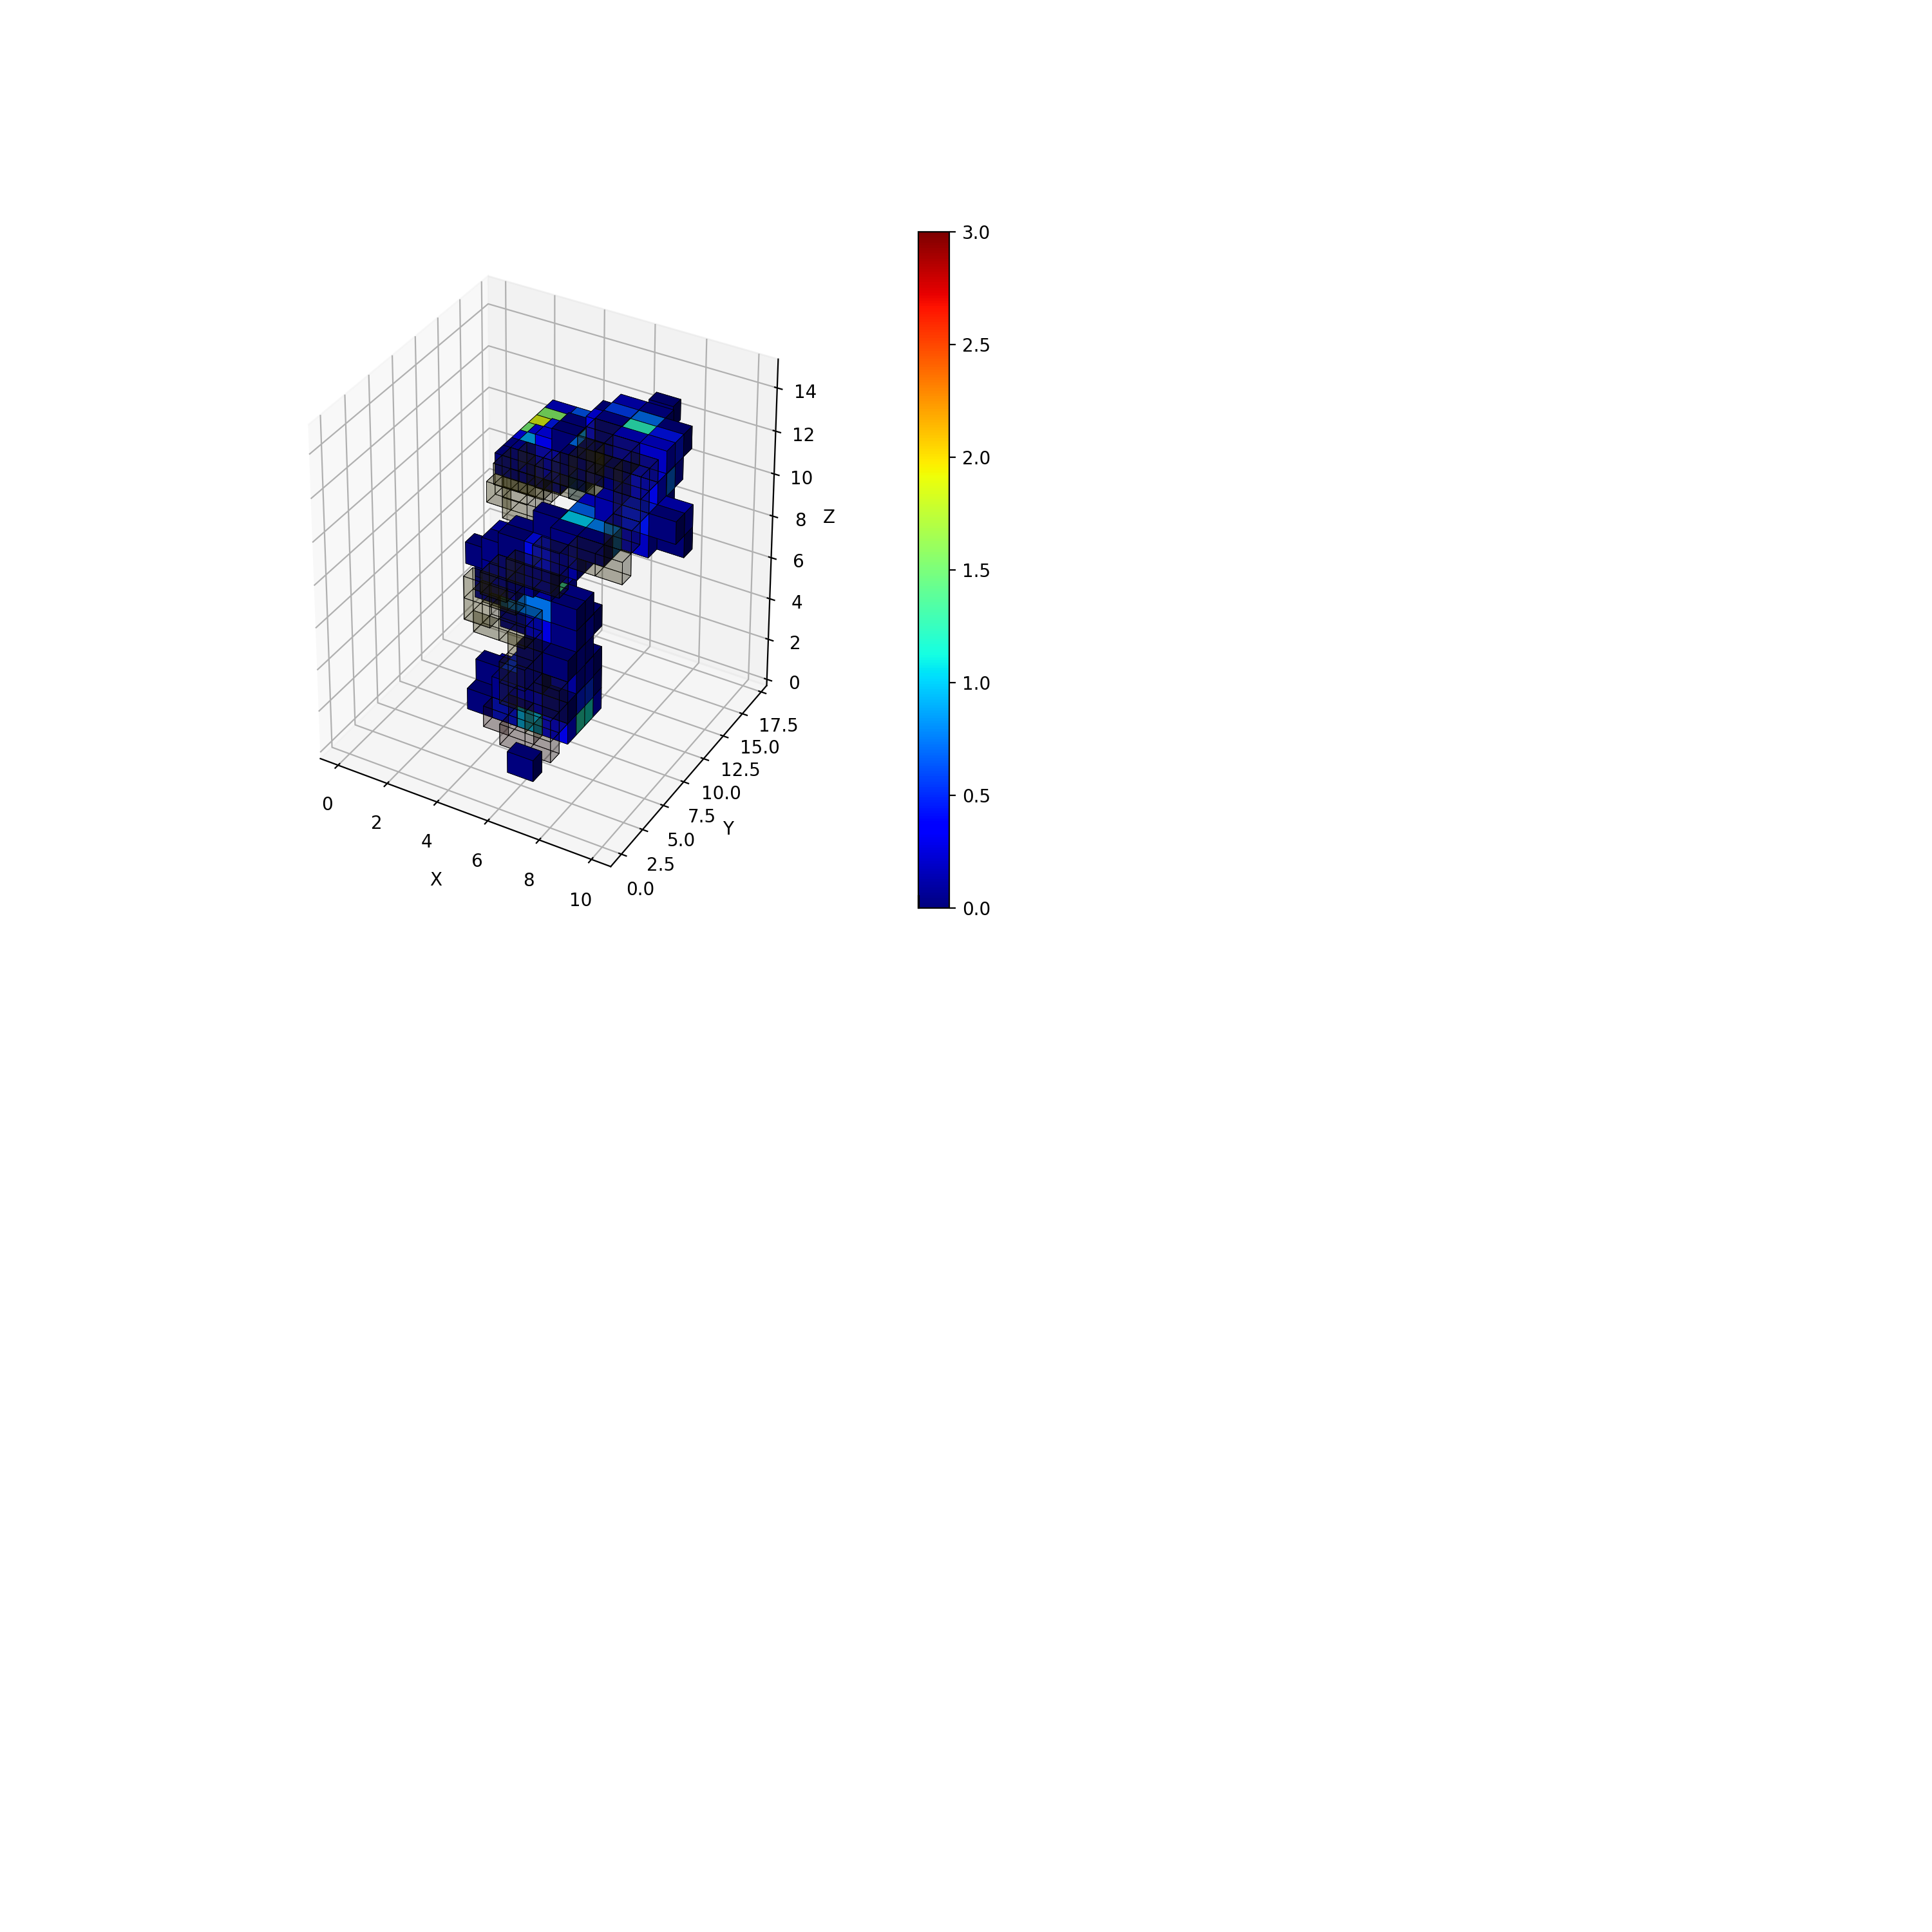

In [12]:
%matplotlib notebook
plot_cloud_voxels(cloud, mc_ev, opacity = .2)

<IPython.core.display.Javascript object>


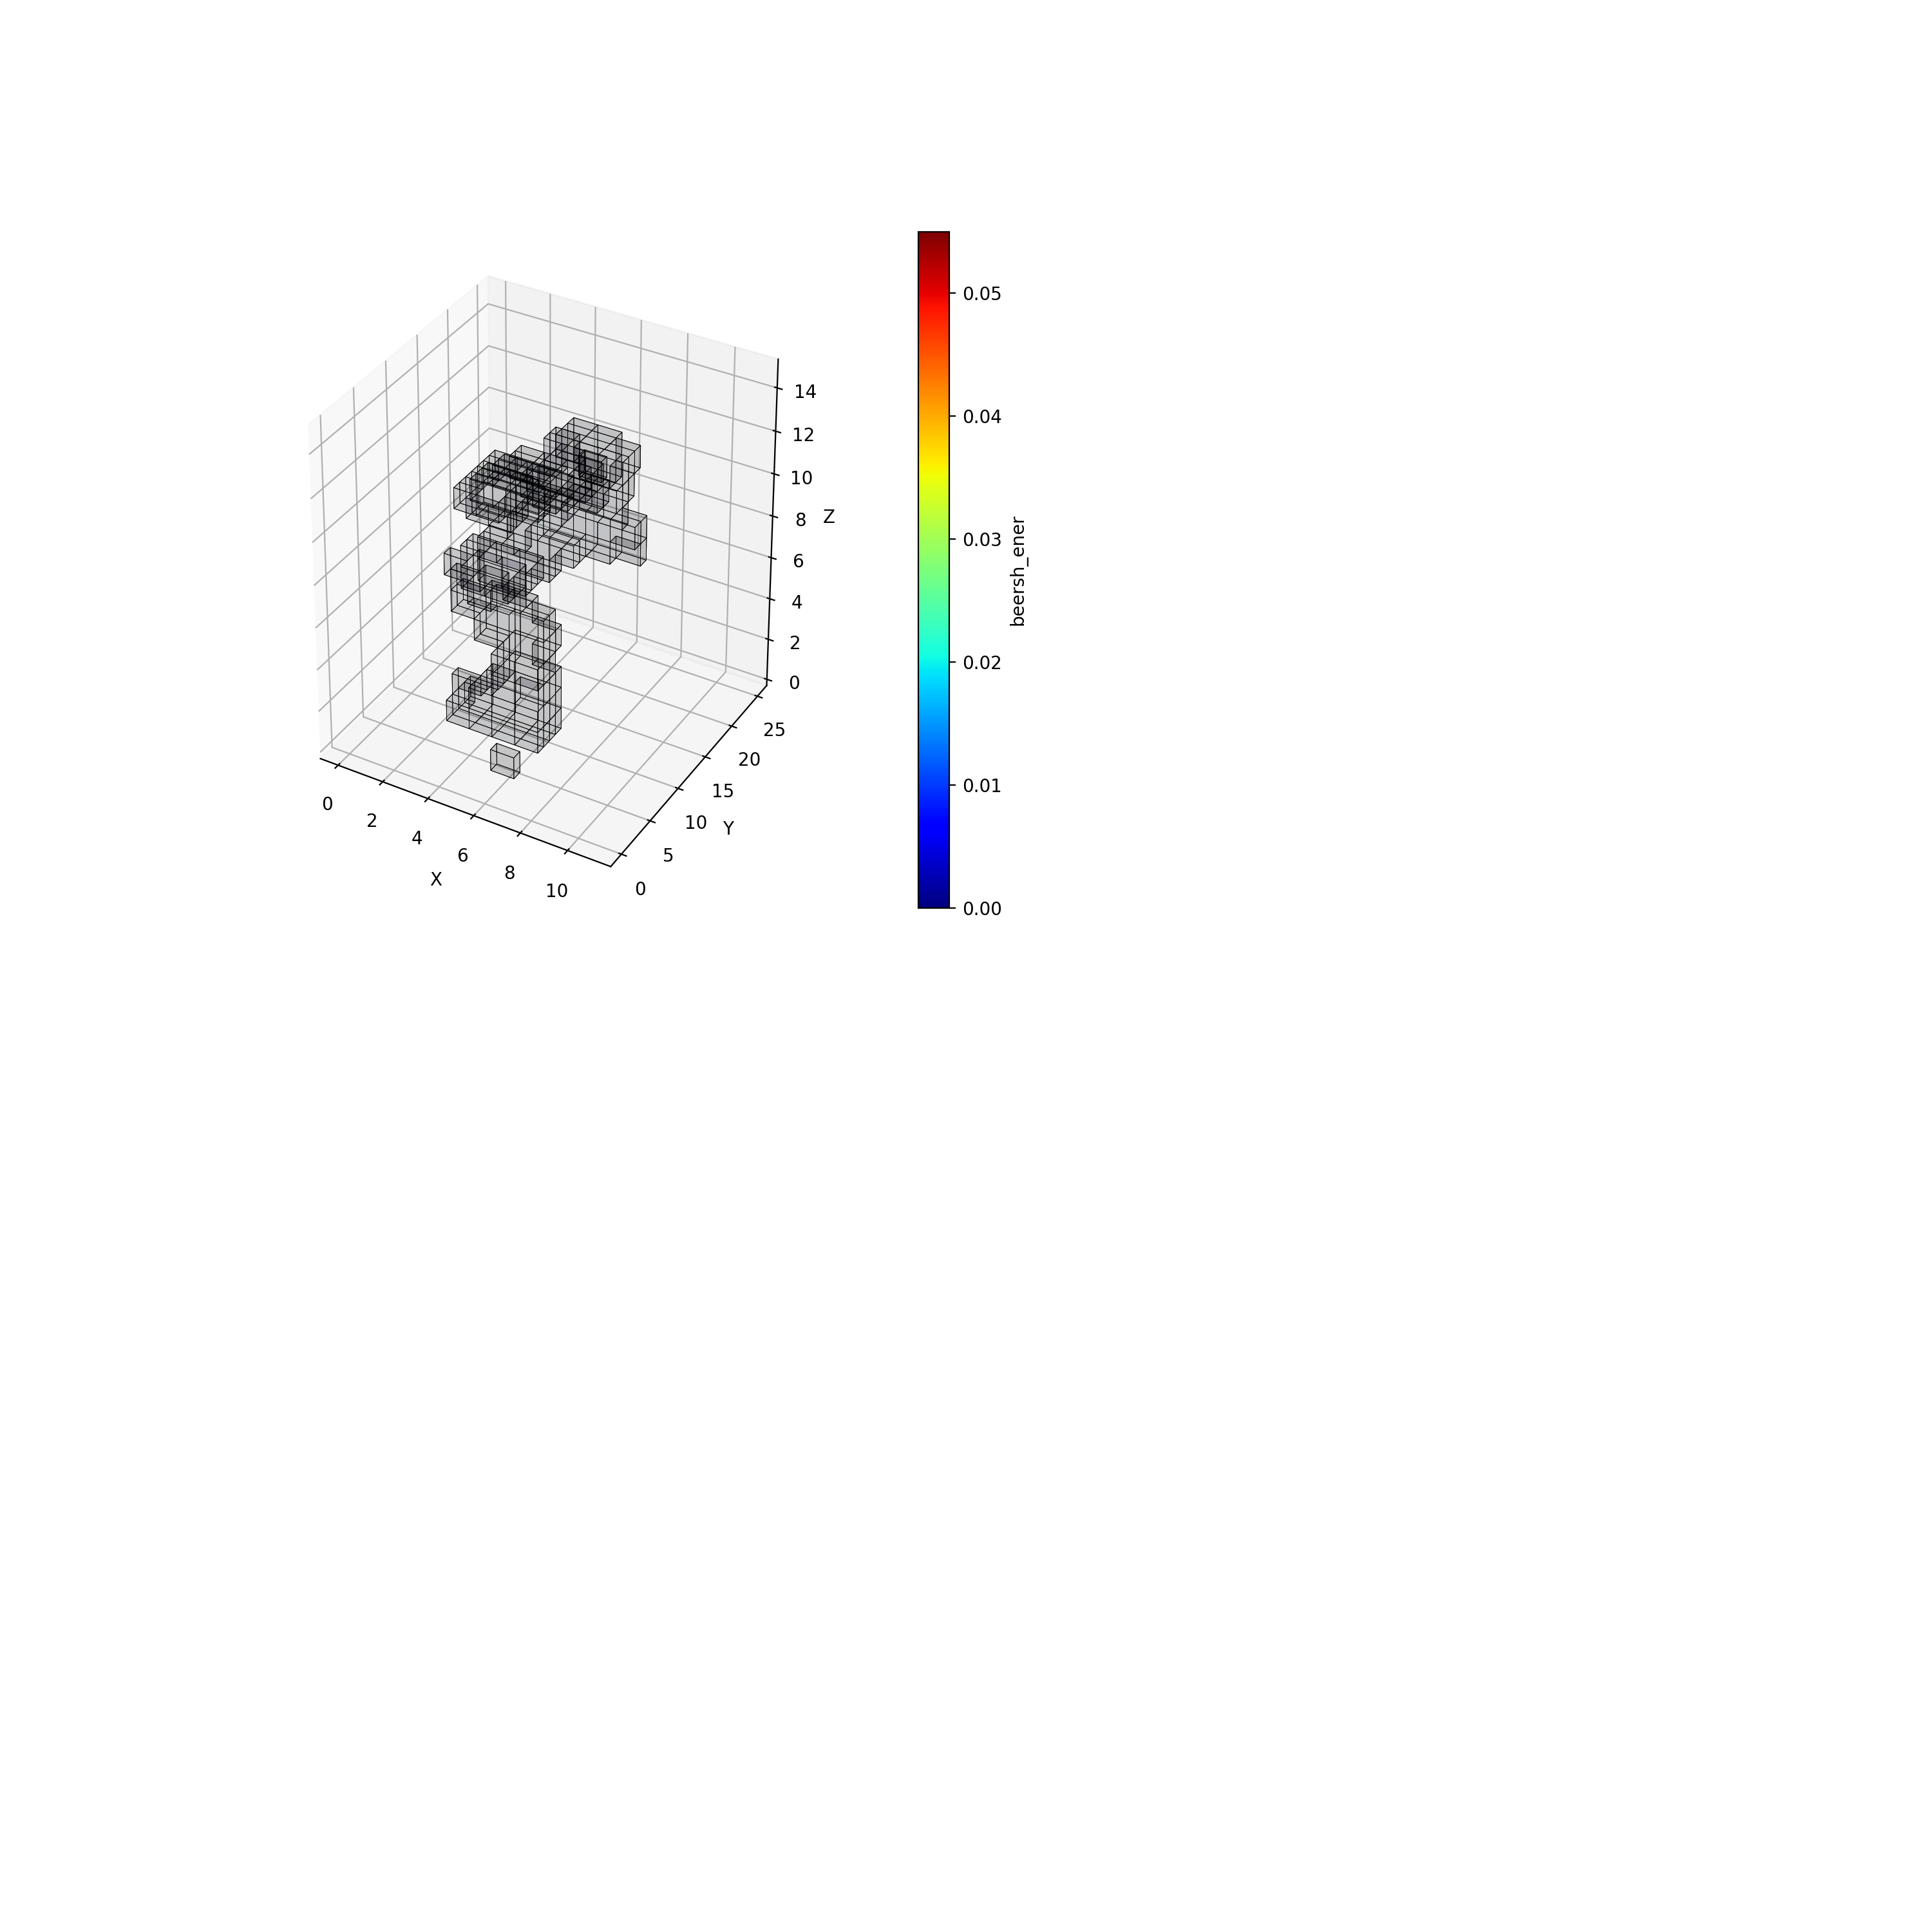

<IPython.core.display.Javascript object>


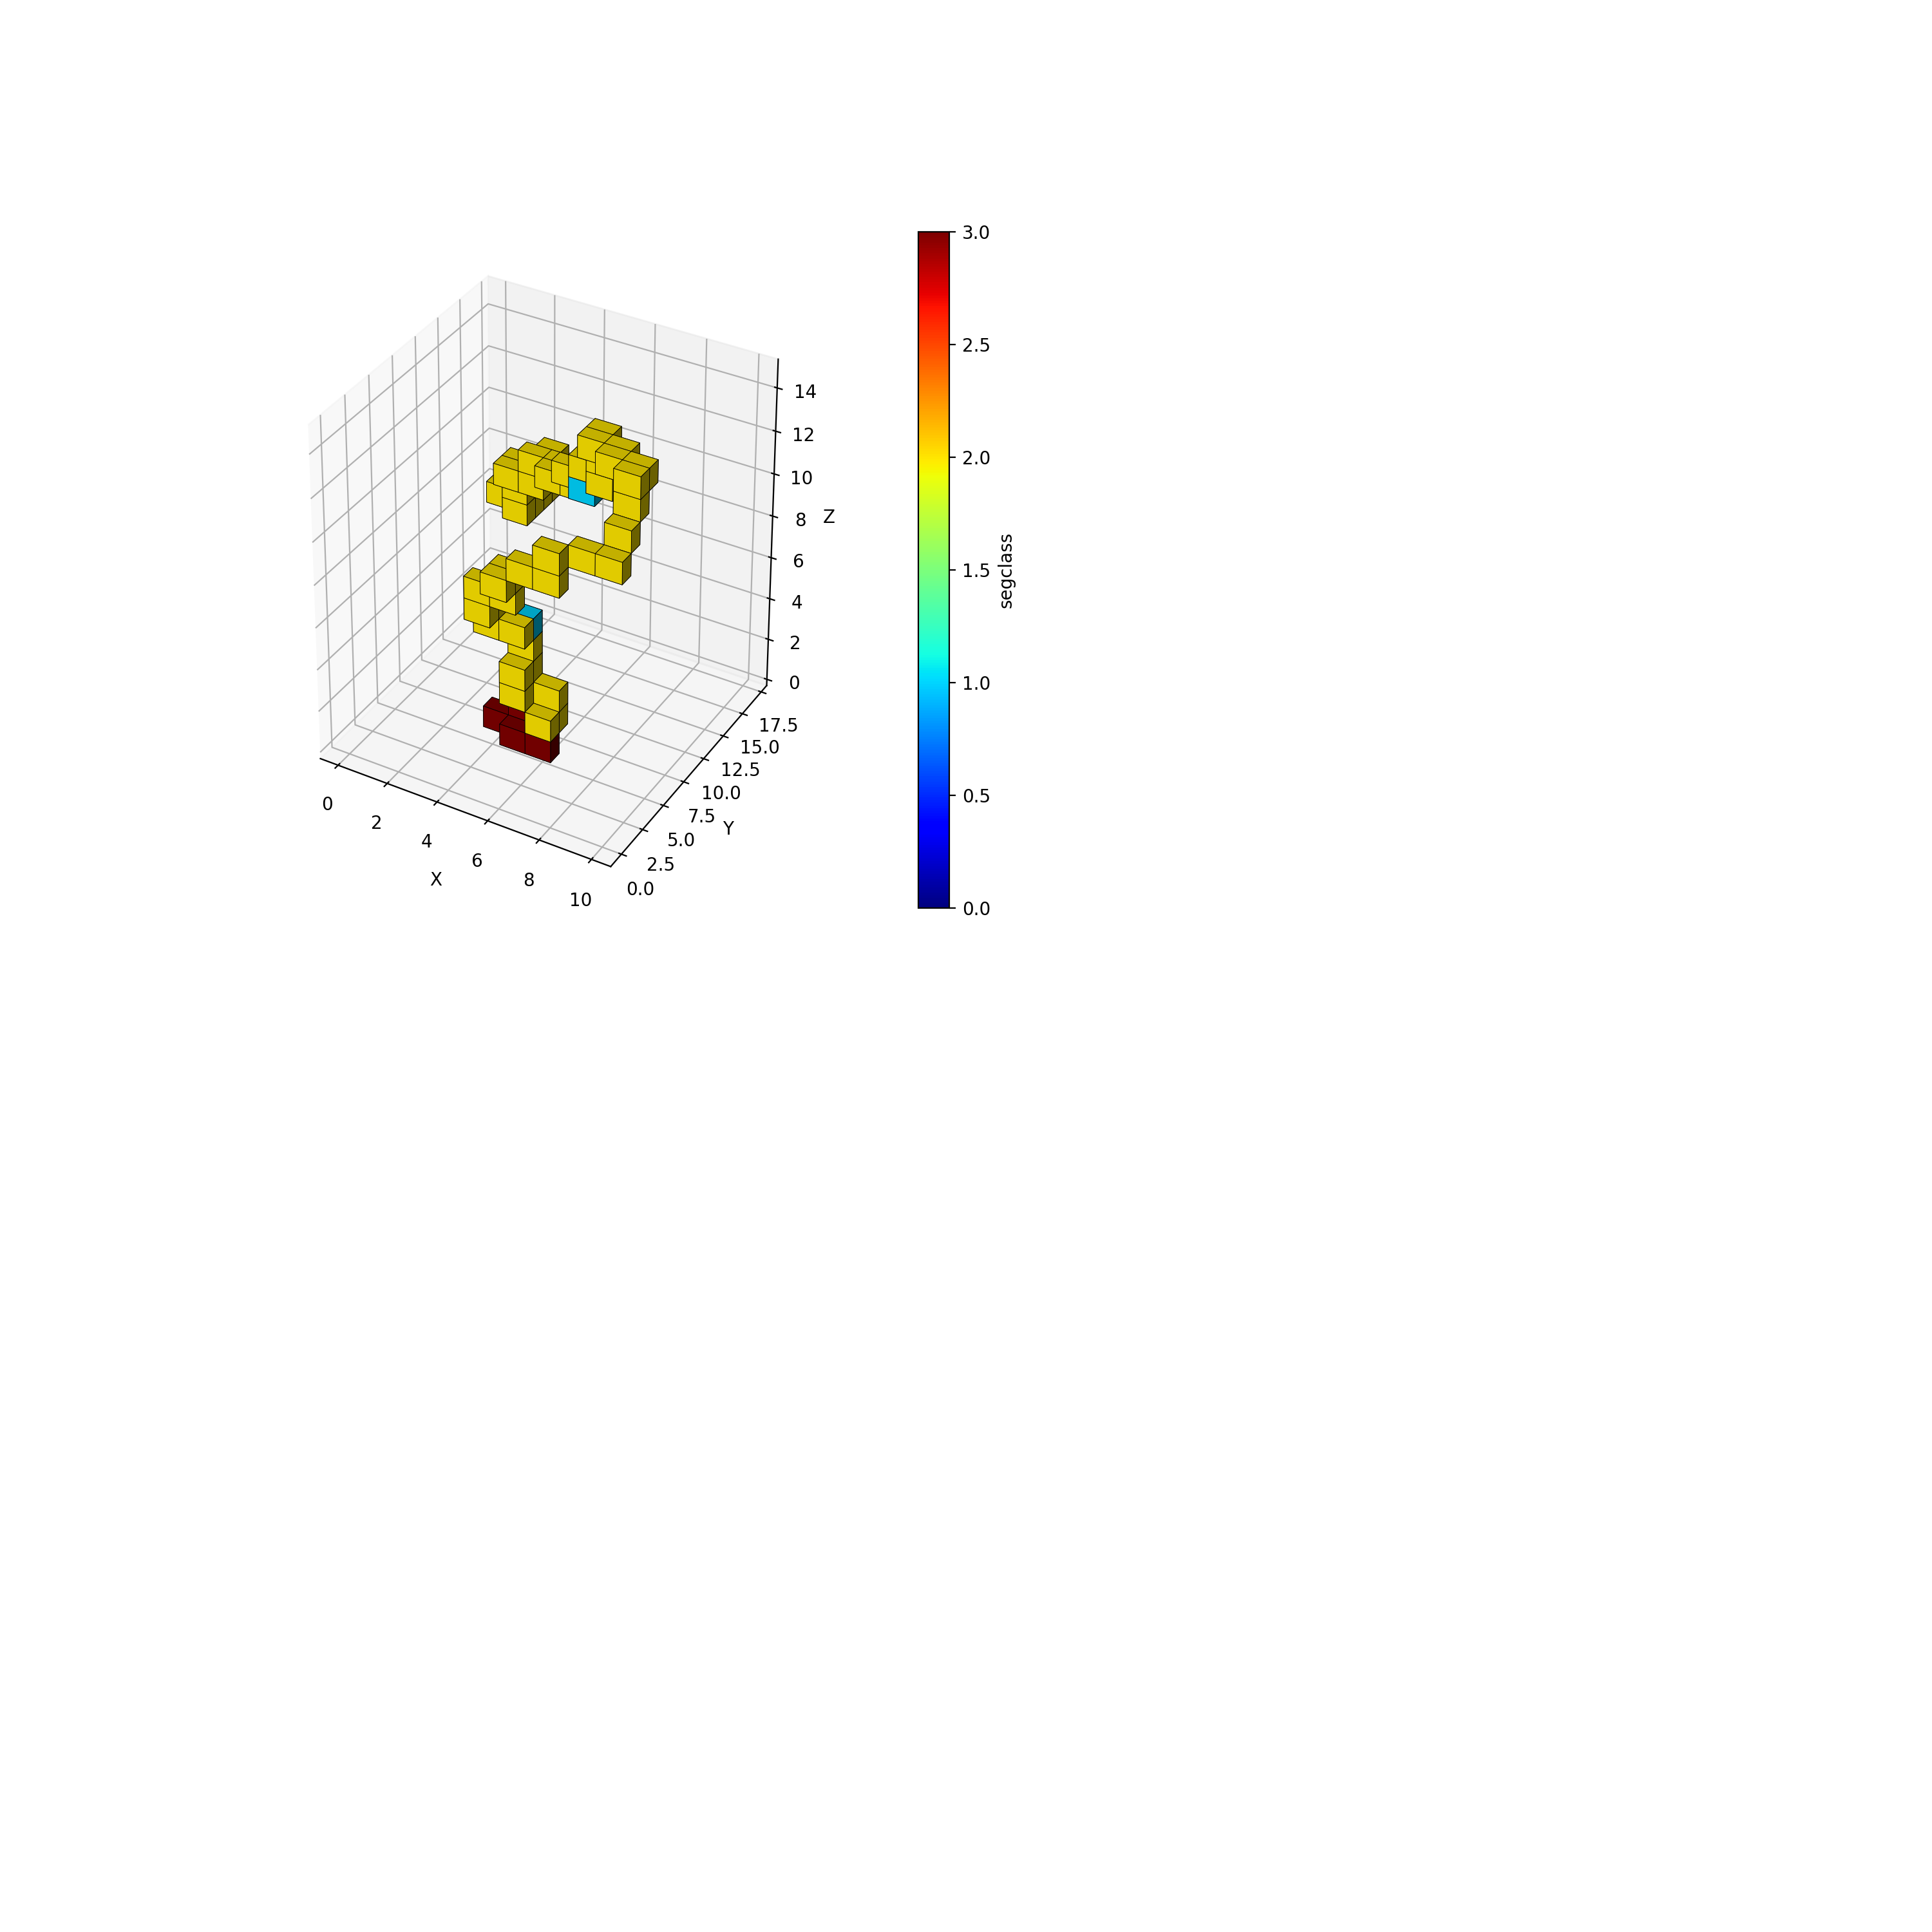

In [13]:
plot_3d_vox(cloud, value = 'beersh_ener', opacity = 0.1)
plot_3d_vox(mc_ev, value = 'segclass')

Veo que muchas veces hay voxeles de MC que no están justamente en los de beersheba.... entonces quizás cuando juntemos dfs no deberíamos perder ninguno de los dos. Rollo yo pensaba que todos los MC estarían dentro de beersh, pero se ve que no, entonces los que no están no los quiero perder pq quizás están pegados a los de beersh y debería igualmente tenerlo en cuenta para labellear como vecino nn sabes...

o quizás los que no están incluidos debería labelear a sus proximos como segclass de verdad, no vecina

Mergeamos, y lo que nos interesa es la segclass, el ratio de la segclass y la binclass. La energía de los voxeles en mc pienso que no me hace falta, aunque tampoco estoy seguro, quizás si para comparar idk...

# COMPORTAMIENTO DE LOS VOXELES QUE SE QUEDAN FUERA

In [14]:
mc_beersh_voxels = beersh_voxels.merge(labelled_voxels[['event_id', 'x', 'y', 'z', 'ener', 'ratio', 'segclass', 'binclass']], on = ['event_id', 'x', 'y', 'z', 'binclass'], how = 'outer')

In [15]:
mc_beersh_voxels = mc_beersh_voxels.sort_values(['event_id', 'x', 'y']) #ordeno pq no se porque me desordena los
#voxeles de los diferentes eventos

In [16]:
mc_beersh_voxels

,event_id,x,y,z,beersh_ener,binclass,ener,ratio,segclass
0,48000024,-1,32,57,0.000357,0,NaN,NaN,NaN
1,48000024,-1,33,57,0.000561,0,0.029452,1.0,1.0
2,48000024,-1,33,58,0.002432,0,NaN,NaN,NaN
3,48000024,0,32,57,0.001903,0,NaN,NaN,NaN
4,48000024,0,32,58,0.000442,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
104654,48000597,8,-4,59,0.000611,0,0.011978,1.0,2.0
104655,48000597,8,-4,60,0.005414,0,0.008966,1.0,2.0
105447,48000597,8,-3,59,NaN,0,0.000070,1.0,1.0
104656,48000597,9,-5,59,0.000636,0,NaN,NaN,NaN


In [17]:
outside_voxels = mc_beersh_voxels[mc_beersh_voxels.beersh_ener.isnull()]
outside_voxels

,event_id,x,y,z,beersh_ener,binclass,ener,ratio,segclass
104658,48000024,3,32,55,NaN,0,0.004629,1.000000,1.0
104659,48000024,4,32,55,NaN,0,0.005453,1.000000,1.0
104660,48000024,5,36,57,NaN,0,0.012637,1.000000,1.0
104661,48000026,7,-18,51,NaN,0,0.005139,1.000000,2.0
104662,48000027,6,-3,77,NaN,0,0.005076,1.000000,2.0
...,...,...,...,...,...,...,...,...,...
105443,48000592,-8,14,27,NaN,1,0.013613,1.000000,2.0
105444,48000592,-6,13,44,NaN,1,0.003027,1.000000,2.0
105445,48000596,1,18,44,NaN,0,0.003220,0.935288,2.0
105446,48000596,17,14,33,NaN,0,0.009965,1.000000,2.0


In [18]:
inside_voxels = mc_beersh_voxels[mc_beersh_voxels.beersh_ener.notnull() & mc_beersh_voxels.segclass.notnull()]
inside_voxels

,event_id,x,y,z,beersh_ener,binclass,ener,ratio,segclass
1,48000024,-1,33,57,0.000561,0,0.029452,1.0,1.0
24,48000024,3,32,56,0.013227,0,0.022082,1.0,1.0
28,48000024,3,33,56,0.006158,0,0.015947,1.0,1.0
29,48000024,3,33,57,0.017636,0,0.026925,1.0,1.0
33,48000024,3,34,57,0.034474,0,0.159837,1.0,1.0
...,...,...,...,...,...,...,...,...,...
104637,48000597,7,-6,60,0.020441,0,0.027982,1.0,2.0
104651,48000597,8,-6,60,0.010596,0,0.004106,1.0,2.0
104653,48000597,8,-5,60,0.013882,0,0.028640,1.0,2.0
104654,48000597,8,-4,59,0.000611,0,0.011978,1.0,2.0


In [19]:
empty_voxels = mc_beersh_voxels[mc_beersh_voxels.segclass.isnull()]
empty_voxels

,event_id,x,y,z,beersh_ener,binclass,ener,ratio,segclass
0,48000024,-1,32,57,0.000357,0,NaN,NaN,NaN
2,48000024,-1,33,58,0.002432,0,NaN,NaN,NaN
3,48000024,0,32,57,0.001903,0,NaN,NaN,NaN
4,48000024,0,32,58,0.000442,0,NaN,NaN,NaN
5,48000024,0,33,57,0.003264,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
104649,48000597,8,-7,60,0.008677,0,NaN,NaN,NaN
104650,48000597,8,-7,61,0.002144,0,NaN,NaN,NaN
104652,48000597,8,-5,59,0.000269,0,NaN,NaN,NaN
104656,48000597,9,-5,59,0.000636,0,NaN,NaN,NaN


In [20]:
len(outside_voxels) + len(inside_voxels) + len(empty_voxels)

105448

In [21]:
len(mc_beersh_voxels)

105448

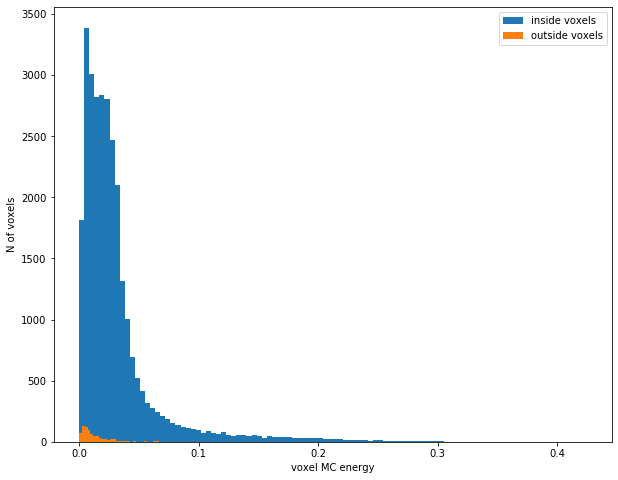

In [22]:
%matplotlib inline
plt.figure(figsize = (10, 8))
plt.hist(inside_voxels.ener, bins = 100, label = 'inside voxels')
plt.hist(outside_voxels.ener, bins = 100, label = 'outside voxels')
plt.legend()
plt.xlabel('voxel MC energy')
plt.ylabel('N of voxels')
plt.show()

In [23]:
print('El ratio de voxeles fuera respecto a los totales de MC es',len(outside_voxels)/len(labelled_voxels))

El ratio de voxeles fuera respecto a los totales de MC es 0.026893617021276597


In [24]:
len(outside_voxels[outside_voxels.segclass == 1]), len(outside_voxels[outside_voxels.segclass == 2]), len(outside_voxels[outside_voxels.segclass == 3])

(121, 641, 28)

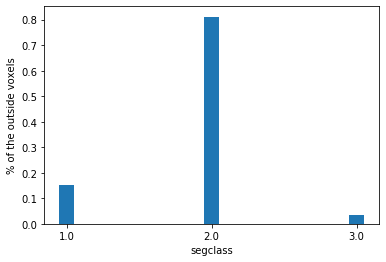

In [25]:
data = outside_voxels.segclass
height, x = np.histogram(data, bins = len(data.unique()), weights=np.ones(len(data)) / len(data))
plt.bar(np.arange(1, 4), height, width = 0.1, tick_label = data.unique())
plt.xlabel('segclass')
plt.ylabel('% of the outside voxels')
plt.show()

In [26]:
out_segclass, _ = np.histogram(data, bins = len(data.unique()))
out_segclass

array([121, 641,  28])

In [27]:
for i, n in zip(data.unique(), out_segclass):
    print('El porcentaje de voxels de clase', i, 'que son outside, del total de los etiquetados como su clase, es',
         n/len(labelled_voxels[labelled_voxels.segclass == i]))

El porcentaje de voxels de clase 1.0 que son outside, del total de los etiquetados como su clase, es 0.03224087396749267
El porcentaje de voxels de clase 2.0 que son outside, del total de los etiquetados como su clase, es 0.02772611272113846
El porcentaje de voxels de clase 3.0 que son outside, del total de los etiquetados como su clase, es 0.011186576108669596


# TRATAMOS LOS VOXELES DE MC QUE QUEDAN FUERA

Primero aquí lo hago individualmente para un evento pero luego ya construyo la función

In [28]:
merged_voxels = mc_beersh_voxels[mc_beersh_voxels.event_id == 48000034]

In [29]:
merged_voxels

,event_id,x,y,z,beersh_ener,binclass,ener,ratio,segclass
1723,48000034,-11,16,65,0.001262,0,NaN,NaN,NaN
1724,48000034,-11,16,66,0.003292,0,NaN,NaN,NaN
1725,48000034,-11,17,65,0.002283,0,NaN,NaN,NaN
1726,48000034,-11,17,66,0.000174,0,NaN,NaN,NaN
1727,48000034,-10,14,66,0.001138,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1926,48000034,0,14,60,0.002843,0,NaN,NaN,NaN
1927,48000034,0,14,61,0.002772,0,NaN,NaN,NaN
1928,48000034,0,15,59,0.002590,0,NaN,NaN,NaN
1929,48000034,0,16,59,0.000826,0,NaN,NaN,NaN


In [30]:
merged_voxels

,event_id,x,y,z,beersh_ener,binclass,ener,ratio,segclass
1723,48000034,-11,16,65,0.001262,0,NaN,NaN,NaN
1724,48000034,-11,16,66,0.003292,0,NaN,NaN,NaN
1725,48000034,-11,17,65,0.002283,0,NaN,NaN,NaN
1726,48000034,-11,17,66,0.000174,0,NaN,NaN,NaN
1727,48000034,-10,14,66,0.001138,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1926,48000034,0,14,60,0.002843,0,NaN,NaN,NaN
1927,48000034,0,14,61,0.002772,0,NaN,NaN,NaN
1928,48000034,0,15,59,0.002590,0,NaN,NaN,NaN
1929,48000034,0,16,59,0.000826,0,NaN,NaN,NaN


Primero supongo que lo que haré será coger los voxeles de MC que quedaron fuera y buscar el voxel más cercano de beersheba para etiquetarlo igual, nada de 'vecino de'... 

Luego supongo que eliminaré dichos voxeles, son poquitos, en el caso que probé eran 6 solo pero bueno, cunde tener y tal...

Clasificamos los voxeles en 3 grupos:
- Voxeles de MC que no coinciden con los de beersheba (y por tanto están fuera)
- Voxeles de MC que sí coinciden con los de beersheba (nos dan directamente la etiqueta del voxel de beersheba)
- Voxeles de beersheba que quedaron vacíos (los llenaré con clases vecinos)

In [31]:
out_df = merged_voxels[merged_voxels.beersh_ener.isnull()]
ins_df = merged_voxels[merged_voxels.beersh_ener.notnull() & merged_voxels.segclass.notnull()]
emp_df = merged_voxels[merged_voxels.segclass.isnull()]

In [32]:
num_outside_voxels = len(out_df)
num_inside_voxels  = len(ins_df)
num_empty_voxels   = len(emp_df)

In [33]:
num_outside_voxels, num_inside_voxels, num_empty_voxels

(6, 56, 152)

In [34]:
out_df

,event_id,x,y,z,beersh_ener,binclass,ener,ratio,segclass
104670,48000034,-7,16,66,NaN,0,0.009891,1.0,2.0
104671,48000034,-6,15,66,NaN,0,0.011157,1.0,2.0
104672,48000034,-6,17,64,NaN,0,0.021668,1.0,2.0
104673,48000034,-6,17,65,NaN,0,0.008209,1.0,2.0
104674,48000034,-4,20,56,NaN,0,0.006411,1.0,2.0
104675,48000034,-2,13,66,NaN,0,0.011644,1.0,2.0


In [35]:
emp_df

,event_id,x,y,z,beersh_ener,binclass,ener,ratio,segclass
1723,48000034,-11,16,65,0.001262,0,NaN,NaN,NaN
1724,48000034,-11,16,66,0.003292,0,NaN,NaN,NaN
1725,48000034,-11,17,65,0.002283,0,NaN,NaN,NaN
1726,48000034,-11,17,66,0.000174,0,NaN,NaN,NaN
1727,48000034,-10,14,66,0.001138,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1926,48000034,0,14,60,0.002843,0,NaN,NaN,NaN
1927,48000034,0,14,61,0.002772,0,NaN,NaN,NaN
1928,48000034,0,15,59,0.002590,0,NaN,NaN,NaN
1929,48000034,0,16,59,0.000826,0,NaN,NaN,NaN


Vamos a hacer las combinaciones entre out y emp

In [36]:
combinations = pd.merge(out_df, emp_df[['event_id', 'x', 'y', 'z']], on = ['event_id'])[['event_id', 'x_x', 'y_x', 'z_x', 'x_y', 'y_y', 'z_y', 'segclass', 'ratio']]

In [37]:
combinations['distances'] = np.linalg.norm(combinations[['x_x', 'y_x', 'z_x']].values 
                                              - combinations[['x_y', 'y_y', 'z_y']].values, axis=1)

In [38]:
combinations

,event_id,x_x,y_x,z_x,x_y,y_y,z_y,segclass,ratio,distances
0,48000034,-7,16,66,-11,16,65,2.0,1.0,4.123106
1,48000034,-7,16,66,-11,16,66,2.0,1.0,4.000000
2,48000034,-7,16,66,-11,17,65,2.0,1.0,4.242641
3,48000034,-7,16,66,-11,17,66,2.0,1.0,4.123106
4,48000034,-7,16,66,-10,14,66,2.0,1.0,3.605551
...,...,...,...,...,...,...,...,...,...,...
907,48000034,-2,13,66,0,14,60,2.0,1.0,6.403124
908,48000034,-2,13,66,0,14,61,2.0,1.0,5.477226
909,48000034,-2,13,66,0,15,59,2.0,1.0,7.549834
910,48000034,-2,13,66,0,16,59,2.0,1.0,7.874008


In [39]:
prueba = merged_voxels

En switching voxels df meto los voxeles que son candidatos a ser labelleados por proximidad con un voxel monte carlo que no tuvo oportunidad de impregnar con su clase a ningún voxel de beersheba, es decir, que es un out_vox

In [40]:
switching_voxels_df = pd.DataFrame()

In [41]:
for event_id, df in combinations.groupby(['event_id', 'x_x', 'y_x', 'z_x']):
    min_dist = min(df.distances)
    print(event_id)
    df = df[df.distances == min_dist].drop(['x_x', 'y_x', 'z_x', 'distances'], axis = 1)
    df = df.rename(columns = {'x_y':'x', 'y_y':'y', 'z_y':'z'})
    switching_voxels_df = switching_voxels_df.append(df)
    #prueba = prueba.merge(df, on = ['event_id', 'x', 'y', 'z'], how = 'outer')
    #prueba['segclass'] = prueba['segclass_y'].fillna(prueba['segclass_x'])
    #prueba = prueba.drop(['segclass_x', 'segclass_y'], axis = 1)

(48000034, -7, 16, 66)
(48000034, -6, 15, 66)
(48000034, -6, 17, 64)
(48000034, -6, 17, 65)
(48000034, -4, 20, 56)
(48000034, -2, 13, 66)


Vale, de la forma que tenía antes si dos blobs etiquetados están a la misma distancia de uno que no, se lleva la etiqueta del último. Quizás lo que debería hacer es, cuando vaya a asignar una etiqueta comprobar antes si tiene valor nulo. Si lo tiene, adelante. Si no lo tiene, quizás deberíamos comprobar cual de los voxeles etiquetados tiene mayor valor de RATIO y por tanto más 'certeza' de ser quien es en las cercanías de dicho voxel...

Quizás antes de esto simplemente comprobar si hay algún voxel vacío que se repita, y si es el caso pero a ambos planeo asignarles la misma etiqueta, pues adelante, y si no pues hacer lo que acabo de decir...

Veré en distintos stages lo que sucede con los voxeles conflictivos que están en conflict_vox_df (que se meten por tener distancia 0 es decir ser el mismo voxel repetido):

- Primero miro si son la misma segclass. Si es así, añado su index a la lista de index de dropear Y ADEMÁS lo dropeo también de la lista de conflicto. Este proceso lo hago en cada punto, así va quedando libre la lista de conflicto para el siguiente stage, y al mismo tiempo guardo el indice para luego eliminarlo de la lista de switching_voxels (que es la lista de voxeles a los que le voy a proporcionar una clase)

- Luego, dentro de los que NO son de la misma segclass (es decir, los que sobraron de antes), miro su ratio. Si es el mismo ratio, puedo hacer 2 cosas. Una es eliminar aleatoriamente uno de los dos voxeles... Y otra es asignarle el de mayor segclass (por el tema de pues que quizás es importante ese voxel ya que es un blob y todo eso...). Pienso que voy a hacer lo segundo, así ya me queda el método para repetirlo cuando el ratio no sea el mismo, que es el último stage.

- Por último, si el ratio es distinto, nos quedamos con la label del que más ratio tenga

Si el is_same_segclass es positivo, es que el current indice es el que NO hay que dropear, hay que dropear el anterior (DE LA LISTA DE SWITCHING_VOXELS OBV). Si es negativo, SI lo dropeamos. Voy a hacerlo en un df inventado para ver q tal...

In [42]:
switching_voxels_df = switching_voxels_df.sort_values(['x', 'y', 'z']) #puedo añadir el 'z' en el de ordenar pero no 
#cambia nada porque ya están los otros dos fijados

In [43]:
switching_voxels_df

,event_id,x,y,z,segclass,ratio
34,48000034,-8,16,66,2.0,1.0
50,48000034,-7,15,66,2.0,1.0
202,48000034,-7,15,66,2.0,1.0
358,48000034,-7,17,64,2.0,1.0
511,48000034,-7,17,65,2.0,1.0
212,48000034,-6,15,65,2.0,1.0
366,48000034,-6,17,63,2.0,1.0
681,48000034,-5,19,56,2.0,1.0
682,48000034,-5,20,55,2.0,1.0
698,48000034,-4,19,55,2.0,1.0


In [44]:
switching_voxels_df[['x1', 
                     'y1', 
                     'z1', 
                     'segclass1', 
                     'ratio1']] = switching_voxels_df[['x', 
                                                       'y', 
                                                       'z', 
                                                       'segclass', 
                                                       'ratio']].shift(1)

In [45]:
switching_voxels_df['dist'] = np.linalg.norm(switching_voxels_df[['x', 'y', 'z']].values 
                                              - switching_voxels_df[['x1', 'y1', 'z1']].values, axis=1)

In [46]:
switching_voxels_df['is_same_segclass'] = switching_voxels_df.segclass.values - switching_voxels_df.segclass1.values

In [47]:
switching_voxels_df['is_same_ratio'] = switching_voxels_df.ratio.values - switching_voxels_df.ratio1.values

In [48]:
switching_voxels_df

,event_id,x,y,z,segclass,ratio,x1,y1,z1,segclass1,ratio1,dist,is_same_segclass,is_same_ratio
34,48000034,-8,16,66,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,48000034,-7,15,66,2.0,1.0,-8.0,16.0,66.0,2.0,1.0,1.414214,0.0,0.0
202,48000034,-7,15,66,2.0,1.0,-7.0,15.0,66.0,2.0,1.0,0.000000,0.0,0.0
358,48000034,-7,17,64,2.0,1.0,-7.0,15.0,66.0,2.0,1.0,2.828427,0.0,0.0
511,48000034,-7,17,65,2.0,1.0,-7.0,17.0,64.0,2.0,1.0,1.000000,0.0,0.0
212,48000034,-6,15,65,2.0,1.0,-7.0,17.0,65.0,2.0,1.0,2.236068,0.0,0.0
366,48000034,-6,17,63,2.0,1.0,-6.0,15.0,65.0,2.0,1.0,2.828427,0.0,0.0
681,48000034,-5,19,56,2.0,1.0,-6.0,17.0,63.0,2.0,1.0,7.348469,0.0,0.0
682,48000034,-5,20,55,2.0,1.0,-5.0,19.0,56.0,2.0,1.0,1.414214,0.0,0.0
698,48000034,-4,19,55,2.0,1.0,-5.0,20.0,55.0,2.0,1.0,1.414214,0.0,0.0


Dentro de los voxeles a cambiar miro cuales tienen conflicto, es decir, si dos voxeles están repetidos en la lista

In [49]:
conflict_vox_df = switching_voxels_df[switching_voxels_df.dist == 0]

In [50]:
conflict_vox_df

,event_id,x,y,z,segclass,ratio,x1,y1,z1,segclass1,ratio1,dist,is_same_segclass,is_same_ratio
202,48000034,-7,15,66,2.0,1.0,-7.0,15.0,66.0,2.0,1.0,0.0,0.0,0.0


Añado a la lista los elementos que tienen is_same_segclass = 0

In [51]:
#dropping_index = np.array(conflict_vox_df[conflict_vox_df.is_same_segclass == 0].index)
#cambio esto por lo siguiente

Estoy intentando eliminar siempre los anteriores que tengan la same segclass (es decir, no los que están en conflict voxels) a ver si esto solucionaaa concha

In [52]:
switching_voxels_idx = np.array(switching_voxels_df.index)

In [53]:
dropping_index = np.array([])
for i in conflict_vox_df[conflict_vox_df.is_same_segclass == 0].index:
    dropping_index = np.append(dropping_index, switching_voxels_idx[int(np.where(switching_voxels_df.index == i)[0] - 1)])

In [54]:
dropping_index

array([50.])

Ahora escojo el df de voxeles conflictivos con is_same_ratio 0

In [55]:
switching_voxels_df

,event_id,x,y,z,segclass,ratio,x1,y1,z1,segclass1,ratio1,dist,is_same_segclass,is_same_ratio
34,48000034,-8,16,66,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,48000034,-7,15,66,2.0,1.0,-8.0,16.0,66.0,2.0,1.0,1.414214,0.0,0.0
202,48000034,-7,15,66,2.0,1.0,-7.0,15.0,66.0,2.0,1.0,0.000000,0.0,0.0
358,48000034,-7,17,64,2.0,1.0,-7.0,15.0,66.0,2.0,1.0,2.828427,0.0,0.0
511,48000034,-7,17,65,2.0,1.0,-7.0,17.0,64.0,2.0,1.0,1.000000,0.0,0.0
212,48000034,-6,15,65,2.0,1.0,-7.0,17.0,65.0,2.0,1.0,2.236068,0.0,0.0
366,48000034,-6,17,63,2.0,1.0,-6.0,15.0,65.0,2.0,1.0,2.828427,0.0,0.0
681,48000034,-5,19,56,2.0,1.0,-6.0,17.0,63.0,2.0,1.0,7.348469,0.0,0.0
682,48000034,-5,20,55,2.0,1.0,-5.0,19.0,56.0,2.0,1.0,1.414214,0.0,0.0
698,48000034,-4,19,55,2.0,1.0,-5.0,20.0,55.0,2.0,1.0,1.414214,0.0,0.0


In [56]:
ratio0 = conflict_vox_df[conflict_vox_df.is_same_ratio == 0]

Ahora voy a meter los índices de los voxeles anteriores a los que tienen segclass positiva

In [57]:
ratio0

,event_id,x,y,z,segclass,ratio,x1,y1,z1,segclass1,ratio1,dist,is_same_segclass,is_same_ratio
202,48000034,-7,15,66,2.0,1.0,-7.0,15.0,66.0,2.0,1.0,0.0,0.0,0.0


In [58]:
segclass_pos_index = np.array(ratio0[ratio0.is_same_segclass > 0].index)

In [59]:
for i in segclass_pos_index:
    dropping_index = np.append(dropping_index, switching_voxels_idx[int(np.where(switching_voxels_idx == i)[0]) - 1])

In [60]:
dropping_index

array([50.])

Ahora añado indices de los que tienen segclass negativa

In [61]:
dropping_index = np.append(dropping_index, np.array(ratio0[ratio0.is_same_segclass < 0].index))

In [62]:
dropping_index

array([50.])

Escojo los que quedan (ni segclass ni ratio nulo)

In [63]:
last_vox = conflict_vox_df[(conflict_vox_df.is_same_segclass != 0) 
                                    & (conflict_vox_df.is_same_ratio != 0)]

Meto los indices anteriores a los que tienen un ratio positivo

In [64]:
ratio_pos_index = np.array(last_vox[last_vox.is_same_ratio > 0].index)

In [65]:
for i in ratio_pos_index:
    dropping_index = np.append(dropping_index, switching_voxels_idx[int(np.where(switching_voxels_idx == i)[0]) - 1])

Meto los indices de ratio negativo

In [66]:
dropping_index = np.append(dropping_index, np.array(last_vox[last_vox.is_same_ratio < 0].index))

In [67]:
dropping_index

array([50.])

Finalmente elimino los voxeles de las listas

In [68]:
switching_voxels_df = switching_voxels_df.drop(dropping_index)

In [69]:
switching_voxels_df

,event_id,x,y,z,segclass,ratio,x1,y1,z1,segclass1,ratio1,dist,is_same_segclass,is_same_ratio
34,48000034,-8,16,66,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202,48000034,-7,15,66,2.0,1.0,-7.0,15.0,66.0,2.0,1.0,0.000000,0.0,0.0
358,48000034,-7,17,64,2.0,1.0,-7.0,15.0,66.0,2.0,1.0,2.828427,0.0,0.0
511,48000034,-7,17,65,2.0,1.0,-7.0,17.0,64.0,2.0,1.0,1.000000,0.0,0.0
212,48000034,-6,15,65,2.0,1.0,-7.0,17.0,65.0,2.0,1.0,2.236068,0.0,0.0
366,48000034,-6,17,63,2.0,1.0,-6.0,15.0,65.0,2.0,1.0,2.828427,0.0,0.0
681,48000034,-5,19,56,2.0,1.0,-6.0,17.0,63.0,2.0,1.0,7.348469,0.0,0.0
682,48000034,-5,20,55,2.0,1.0,-5.0,19.0,56.0,2.0,1.0,1.414214,0.0,0.0
698,48000034,-4,19,55,2.0,1.0,-5.0,20.0,55.0,2.0,1.0,1.414214,0.0,0.0
717,48000034,-3,19,56,2.0,1.0,-4.0,19.0,55.0,2.0,1.0,1.414214,0.0,0.0


In [70]:
#prueba = prueba.merge(df, on = ['event_id', 'x', 'y', 'z'], how = 'outer')
    #prueba['segclass'] = prueba['segclass_y'].fillna(prueba['segclass_x'])
    #prueba = prueba.drop(['segclass_x', 'segclass_y'], axis = 1)

In [71]:
switching_voxels_df = switching_voxels_df[['event_id', 'x', 'y', 'z', 'segclass']]

In [72]:
merged_voxels = merged_voxels.merge(switching_voxels_df, on = ['event_id', 'x', 'y', 'z'], how = 'outer')
merged_voxels['segclass'] = merged_voxels['segclass_y'].fillna(merged_voxels['segclass_x'])
merged_voxels = merged_voxels.drop(['segclass_x', 'segclass_y'], axis = 1)

In [73]:
merged_voxels = merged_voxels.drop(np.array(merged_voxels[merged_voxels.beersh_ener.isnull()].index))

In [74]:
merged_voxels[merged_voxels[['x', 'y', 'z', 'beersh_ener']].duplicated()]

,event_id,x,y,z,beersh_ener,binclass,ener,ratio,segclass


In [75]:
merged_voxels

,event_id,x,y,z,beersh_ener,binclass,ener,ratio,segclass
0,48000034,-11,16,65,0.001262,0,NaN,NaN,NaN
1,48000034,-11,16,66,0.003292,0,NaN,NaN,NaN
2,48000034,-11,17,65,0.002283,0,NaN,NaN,NaN
3,48000034,-11,17,66,0.000174,0,NaN,NaN,NaN
4,48000034,-10,14,66,0.001138,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
209,48000034,0,14,60,0.002843,0,NaN,NaN,NaN
210,48000034,0,14,61,0.002772,0,NaN,NaN,NaN
211,48000034,0,15,59,0.002590,0,NaN,NaN,NaN
212,48000034,0,16,59,0.000826,0,NaN,NaN,NaN


In [76]:
merged_voxels.drop(np.array(merged_voxels[merged_voxels[['x', 'y', 'z']].duplicated()].index))

,event_id,x,y,z,beersh_ener,binclass,ener,ratio,segclass
0,48000034,-11,16,65,0.001262,0,NaN,NaN,NaN
1,48000034,-11,16,66,0.003292,0,NaN,NaN,NaN
2,48000034,-11,17,65,0.002283,0,NaN,NaN,NaN
3,48000034,-11,17,66,0.000174,0,NaN,NaN,NaN
4,48000034,-10,14,66,0.001138,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
209,48000034,0,14,60,0.002843,0,NaN,NaN,NaN
210,48000034,0,14,61,0.002772,0,NaN,NaN,NaN
211,48000034,0,15,59,0.002590,0,NaN,NaN,NaN
212,48000034,0,16,59,0.000826,0,NaN,NaN,NaN


## Función que hace este ''aprovechamiento'' de los voxeles MC que se quedaron fuera

In [78]:
def label_leftover_voxels_per_event(merged_voxels):
    '''
    Function to remove the leftover voxeles (those MC with no beersheba correspondance) and use them to label
    their nearest(s) empty beersheba voxel(s). It does it per event, so will be used inside a bigger function 
    with a whole file grouped by event.
    Args:
        merged_voxels: DATAFRAME
    This dataframe contains (per EVENT) the MC labelled voxels merged with the beersheba voxels. 
    
    RETURNS:
        merged_voxels: DATAFRAME
    It now contains JUST the beersheba voxels, some of them with new labels, benefiting from the outside MC voxels.
    '''
    out_df = merged_voxels[merged_voxels.beersh_ener.isnull()]
    ins_df = merged_voxels[merged_voxels.beersh_ener.notnull() & merged_voxels.ratio.notnull()]
    emp_df = merged_voxels[merged_voxels.segclass.isnull()]
    
    if out_df.empty:
        #continue
        return merged_voxels
    
    else:
        #Combinations of the outside voxels and the empty to compute distances
        combinations = pd.merge(out_df, 
                                emp_df[['event_id', 'x', 'y', 'z']], 
                                on = ['event_id'])[['event_id', 
                                                    'x_x', 'y_x', 'z_x', 
                                                    'x_y', 'y_y', 'z_y', 
                                                    'segclass', 
                                                    'ratio']]
        combinations['distances'] = np.linalg.norm(combinations[['x_x', 'y_x', 'z_x']].values 
                                              - combinations[['x_y', 'y_y', 'z_y']].values, axis=1)
        #Selection of the nearest empty voxels
        switching_voxels_df = pd.DataFrame()
        for event_id, df in combinations.groupby(['event_id', 'x_x', 'y_x', 'z_x']):
            min_dist = min(df.distances)
            df = df[df.distances == min_dist].drop(['x_x', 'y_x', 'z_x', 'distances'], axis = 1)
            df = df.rename(columns = {'x_y':'x', 'y_y':'y', 'z_y':'z'})
            switching_voxels_df = switching_voxels_df.append(df)
    
        switching_voxels_df = switching_voxels_df.sort_values(['x', 'y', 'z'])
        #From here, the function will be removing repeated voxels with conflicts
        #Calculating the needed quantities to resolve those conflicts
        switching_voxels_df[['x1', 
                             'y1', 
                             'z1', 
                             'segclass1', 
                             'ratio1']] = switching_voxels_df[['x', 
                                                               'y', 
                                                               'z', 
                                                               'segclass', 
                                                               'ratio']].shift(1)
    
        switching_voxels_df['dist'] = np.linalg.norm(switching_voxels_df[['x', 'y', 'z']].values 
                                                  - switching_voxels_df[['x1', 'y1', 'z1']].values, axis=1)
        switching_voxels_df['is_same_segclass'] = switching_voxels_df.segclass.values - switching_voxels_df.segclass1.values
        switching_voxels_df['is_same_ratio'] = switching_voxels_df.ratio.values - switching_voxels_df.ratio1.values
    
        #df of conflictive voxels (those which are repeated)
        conflict_vox_df = switching_voxels_df[switching_voxels_df.dist == 0]
        switching_voxels_idx = np.array(switching_voxels_df.index)
        
        #Adding to an array the indexes of the voxels to remove
        dropping_index = np.array([])
        
        #Dropping those with repeated segclass
        for i in conflict_vox_df[conflict_vox_df.is_same_segclass == 0].index:
            dropping_index = np.append(dropping_index, switching_voxels_idx[int(np.where(switching_voxels_df.index == i)[0] - 1)])
        #dropping_index = np.array(conflict_vox_df[conflict_vox_df.is_same_segclass == 0].index)
        
        #Dropping one of the voxel with same ratio and different segclass (with some cirteria)
        ratio0 = conflict_vox_df[conflict_vox_df.is_same_ratio == 0]
        segclass_pos_index = np.array(ratio0[ratio0.is_same_segclass > 0].index)
        
        for i in segclass_pos_index:
            dropping_index = np.append(dropping_index, switching_voxels_idx[int(np.where(switching_voxels_idx == i)[0]) - 1])
        dropping_index = np.append(dropping_index, np.array(ratio0[ratio0.is_same_segclass < 0].index))
        #Dropping the voxel with less ratio fo two with different ratio and different segclass
        last_vox = conflict_vox_df[(conflict_vox_df.is_same_segclass != 0) 
                                    & (conflict_vox_df.is_same_ratio != 0)]
        ratio_pos_index = np.array(last_vox[last_vox.is_same_ratio > 0].index)
        for i in ratio_pos_index:
            dropping_index = np.append(dropping_index, switching_voxels_idx[int(np.where(switching_voxels_idx == i)[0]) - 1])
        dropping_index = np.append(dropping_index, np.array(last_vox[last_vox.is_same_ratio < 0].index))
    
        switching_voxels_df = switching_voxels_df[['event_id', 'x', 'y', 'z', 'segclass']].drop(dropping_index)
        #Add to the merged df the new labelled voxels and dropping the outside voxels
        merged_voxels = merged_voxels.merge(switching_voxels_df, on = ['event_id', 'x', 'y', 'z'], how = 'outer')
        merged_voxels['segclass'] = merged_voxels['segclass_y'].fillna(merged_voxels['segclass_x'])
        merged_voxels = merged_voxels.drop(['segclass_x', 'segclass_y'], axis = 1)
    
        merged_voxels = merged_voxels.drop(np.array(merged_voxels[merged_voxels.beersh_ener.isnull()].index))
        merged_voxels = merged_voxels.drop(np.array(merged_voxels[merged_voxels[['x', 'y', 'z']].duplicated()].index))
        return merged_voxels
    

In [104]:
def relabelling_outside_voxels(merged_voxels):
    '''
    Function that does the relabelling to a complete file, i.e., it goes through all the events in each file 
    applying the label_leftover_voxels_per_event to each event
    
    Args:
        merged_voxels: DATAFRAME
    This DF contains MC labelled voxels merged with the beersheba voxels, for several events.
    
    RETURNS:
        merged_voxels: DATAFRAME
    Contains just the beersheba voxels, without the outside MC voxels, and with a relabelling done for those
    voxels, for several events.
    '''
    length = len(merged_voxels)
    for event_id, df in merged_voxels.groupby('event_id'):
        no_out_voxels_df = label_leftover_voxels_per_event(df)
        merged_voxels = merged_voxels.merge(no_out_voxels_df[['event_id', 'x', 'y', 'z', 'segclass']], 
                                            on = ['event_id', 'x', 'y', 'z'], how = 'left')
        merged_voxels['segclass'] = merged_voxels['segclass_x'].fillna(merged_voxels['segclass_y'])
        merged_voxels = merged_voxels.drop(['segclass_x', 'segclass_y'], axis = 1)
    
        #Comprobamos que la función de eliminar los voxeles no hace cosas raras al mergear (esto si tal mirar 
        #de poner luego en un test digo yo)
        if len(merged_voxels) != length:
            print('En el evento {} aumentan {} voxeles en merged_voxels, cuando no deberían'.format(event_id, len(merged_voxels) - length))
            length = len(merged_voxels)
            
        prueba = merged_voxels.drop(np.array(merged_voxels[merged_voxels.beersh_ener.isnull()].index))
        if prueba[prueba.event_id == event_id].reset_index(drop = True).equals(no_out_voxels_df.reset_index(drop = True)) != True:
            print('En el evento {} el reasignado de voxeles out no fue bien'.format(event_id))
            
    merged_voxels = merged_voxels.drop(np.array(merged_voxels[merged_voxels.beersh_ener.isnull()].index))
    return merged_voxels

Esto con la nueva voxelización es innecesario, ya incluye la binclass

In [80]:
#beersh_voxels = voxelize_beersh(directory, total_size, voxel_size, start_bin)
#mc_beersh_voxels = beersh_voxels.merge(labelled_voxels[['event_id', 'x', 'y', 'z', 'ener', 'ratio', 'binclass', 'segclass']], on = ['event_id', 'x', 'y', 'z'], how = 'outer')

#for i in mc_beersh_voxels.event_id.unique():
#    bincl = int(mc_beersh_voxels[(mc_beersh_voxels.event_id == i) & mc_beersh_voxels.binclass.notnull()].binclass.unique())
#    mc_beersh_voxels.loc[mc_beersh_voxels.event_id == i, 'binclass']  = mc_beersh_voxels.loc[mc_beersh_voxels.event_id == i, 'binclass'].fillna(bincl)

In [81]:
mc_beersh_voxels = beersh_voxels.merge(labelled_voxels[['event_id', 'x', 'y', 'z', 'ener', 'ratio', 'binclass', 'segclass']], on = ['event_id', 'x', 'y', 'z', 'binclass'], how = 'outer')

In [82]:
mc_beersh_voxels

,event_id,x,y,z,beersh_ener,binclass,ener,ratio,segclass
0,48000024,-1,32,57,0.000357,0,NaN,NaN,NaN
1,48000024,-1,33,57,0.000561,0,0.029452,1.000000,1.0
2,48000024,-1,33,58,0.002432,0,NaN,NaN,NaN
3,48000024,0,32,57,0.001903,0,NaN,NaN,NaN
4,48000024,0,32,58,0.000442,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
105443,48000592,-8,14,27,NaN,1,0.013613,1.000000,2.0
105444,48000592,-6,13,44,NaN,1,0.003027,1.000000,2.0
105445,48000596,1,18,44,NaN,0,0.003220,0.935288,2.0
105446,48000596,17,14,33,NaN,0,0.009965,1.000000,2.0


In [83]:
len(mc_beersh_voxels)

105448

In [84]:
len(beersh_voxels) 

104658

El evento 48000369 por alguna razón no se parece en nada la reconstrucción a su MC :/

In [105]:
mc_beersh_voxels_new = relabelling_outside_voxels(mc_beersh_voxels)

In [106]:
mc_beersh_voxels_new[mc_beersh_voxels_new.beersh_ener.isnull()]

,event_id,x,y,z,beersh_ener,binclass,ener,ratio,segclass


In [107]:
len(mc_beersh_voxels_new) #VAMOOOOS ES IGUAL A LA BEERSH_VOXELS...

104658

Ahora, TODOS los voxeles son de beersheba, es decir, tienen la energía asignada al fukin beersheba :)

Veamos, se cumple que out queda en 0, y que lo que sube en ins baja en emp, manteniendo la suma de ins y emp constante respecto antes de hacer la purga esta. Esa diferencia coincide con el tamaño de switching_voxels_df (ya que muchas veces un out voxel ''impregna'' más de un emp voxel, por tenerlo a la misma distancia, y ninguno entra en conflicto con otro entonces varios son etiquetados a raíz de un solo out voxel!!)

### OJO!!!
Tengo q darme cuenta de que los ins voxels no son los que tienen energía nonula y ratio nonulo, ya que en la función al final solo estoy asignando segclass, el ratio en principio como que ''me olvido'' de asignarlo. Podría hacerlo pero no se si tiene mucho sentido tampoco rollo... me da una información realista?? Lo digo porque una clase okey, pues por cercanía, pero el ratio es un valor muy concreto... no cunde.

Por otra parte... el ratio de los voxeles neighbours tampoco voy a poder hacerlo entiendo entonces no sé si va a tener mucho sentido q lo mantenga en estos voxeles q etiqueté por cercanía como de las clases principales...

# Miramos ahora la comparativa de los voxeles sin la corrección a los outside voxels y con ella...

Esto lo hago para ver si realmente se dió una mejora en el sentido de que si miramos los voxeles de beersheba etiquetados con clases puras podemos ver que las componentes están ahora más conexas, ya que querría decir que se preserva mejor una forma de la traza, o eso entiendo yo

In [88]:
ins_vox = mc_beersh_voxels[mc_beersh_voxels.segclass.notnull() & mc_beersh_voxels.beersh_ener.notnull()]

In [89]:
ins_vox_new = mc_beersh_voxels_new[mc_beersh_voxels_new.segclass.notnull()]

In [90]:
import networkx as nx
import itertools
max_distance = np.sqrt(3)
coincidences = np.array([])
non_coincidences = np.array([])
for (event_id, df), (event_id, df_new) in zip(ins_vox.groupby('event_id'), ins_vox_new.groupby('event_id')):
    nodes = [tuple(x) for x in df[['x', 'y', 'z']].to_numpy()]
    nodes_new = [tuple(x) for x in df_new[['x', 'y', 'z']].to_numpy()] 
    
    graph = nx.Graph()
    graph_new = nx.Graph()
    
    graph.add_nodes_from(nodes)
    graph_new.add_nodes_from(nodes_new)
    
    for va, vb in itertools.combinations(graph.nodes(), 2):
        va_arr, vb_arr = np.array(va), np.array(vb)
        dis = np.linalg.norm(va_arr-vb_arr)
        if dis < max_distance:
            graph.add_edge(va, vb, distance = dis)
            
    for va, vb in itertools.combinations(graph_new.nodes(), 2):
        va_arr, vb_arr = np.array(va), np.array(vb)
        dis = np.linalg.norm(va_arr-vb_arr)
        if dis < max_distance:
            graph_new.add_edge(va, vb, distance = dis)
            
    connected_comp = nx.algorithms.components.number_connected_components(graph)
    connected_comp_new = nx.algorithms.components.number_connected_components(graph_new)
    
    #print('Pre-relabel we had {} connected components, post-relabel we have {}'.format(connected_comp, connected_comp_new))
    #Contamos como exitoso en principio un evento en el que hay menos componentes conexas despues de la corrección
    #Si hay las mismas lo considero como éxito también? No lo sé, es más bien indiferencia
    if connected_comp > connected_comp_new:
        coincidences = np.append(coincidences, True)
    else:
        coincidences = np.append(coincidences, False)
    if connected_comp < connected_comp_new:
        non_coincidences = np.append(non_coincidences, True)
    else:
        non_coincidences = np.append(non_coincidences, False)

Supongo que contamos como exitosa una reducción del número de componentes conectadas porque es como que gracias a eso, los voxeles de beersheba van a tener información más poderosa de cómo era la traza, al tener componentes conectadas sólo por etiquetas del tipo principal

In [91]:
print('Para este evento contamos con un {}% de mejora tras el reetiquetado'.format(sum(coincidences)/len(coincidences)*100))

Para este evento contamos con un 20.87719298245614% de mejora tras el reetiquetado


In [92]:
print('Para este evento contamos con un {}% de empeora tras el reetiquetado'.format(sum(non_coincidences)/len(non_coincidences)*100))

Para este evento contamos con un 14.561403508771932% de empeora tras el reetiquetado


In [93]:
print('El overall improvement tras el etiquetado es entonces {}'.format((sum(coincidences) - sum(non_coincidences))/len(coincidences)*100))

El overall improvement tras el etiquetado es entonces 6.315789473684211


# PRUEBA DE ELIMINACION DE VOXELES

Voy a hacer el codigo con un df de prueba:

In [214]:
voxeles_a_cambiar = pd.DataFrame({'dist':[1, 0, 1, 0, 1, 0, 1, 0, 1, 0], 
                                  'is_same_segclass':[0, 0, 0, 2, 0, -2, 0, 1, 0, 1], 
                                  'is_same_ratio':[0, 0, 0, 0, 0, 0, 0, -0.5, 0, 0.4]}, 
                                 index = [24, 32, 44, 901, 56, 88, 67, 14, 53, 65])

In [215]:
voxeles_a_cambiar

,dist,is_same_segclass,is_same_ratio
24,1,0,0.0
32,0,0,0.0
44,1,0,0.0
901,0,2,0.0
56,1,0,0.0
88,0,-2,0.0
67,1,0,0.0
14,0,1,-0.5
53,1,0,0.0
65,0,1,0.4


In [216]:
voxeles_conflictivos = voxeles_a_cambiar[voxeles_a_cambiar.dist == 0]
voxeles_conflictivos

,dist,is_same_segclass,is_same_ratio
32,0,0,0.0
901,0,2,0.0
88,0,-2,0.0
14,0,1,-0.5
65,0,1,0.4


Primero escojo los que tengan is_same_segclass nula pq ya son para eliminar

In [217]:
index_eliminar = np.array(voxeles_conflictivos[voxeles_conflictivos.is_same_segclass == 0].index) 

Ahora cojo los que tienen ratio 0

In [218]:
ratio0 = voxeles_conflictivos[voxeles_conflictivos.is_same_ratio == 0]

Meto los indices para eliminar de los voxeles anteriores a ratio0 y segclass positiva

In [219]:
segclass_pos_index = np.array(ratio0[ratio0.is_same_segclass > 0].index)

In [220]:
voxeles_a_cambiar_index = np.array(voxeles_a_cambiar.index)

In [221]:
for i in segclass_pos_index:
    index_eliminar = np.append(index_eliminar, voxeles_a_cambiar_index[int(np.where(voxeles_a_cambiar_index == i)[0]) - 1])

Meto los indices para eliminar de los voxeles ratio0 y segclass negativa

In [222]:
index_eliminar = np.append(index_eliminar, np.array(ratio0[ratio0.is_same_segclass < 0].index))

Escojo los que quedan (serán is_segclass y is_ratio distintos de 0)

In [223]:
left_voxeles = voxeles_conflictivos[(voxeles_conflictivos.is_same_segclass != 0) 
                                    & (voxeles_conflictivos.is_same_ratio != 0)]

Cojo indices de los anteriores voxeles a los que tienen el ratio positivo

In [224]:
ratio_pos_index = np.array(left_voxeles[left_voxeles.is_same_ratio > 0].index)

In [225]:
for i in ratio_pos_index:
    index_eliminar = np.append(index_eliminar, voxeles_a_cambiar_index[int(np.where(voxeles_a_cambiar_index == i)[0]) - 1])

Cojo indices de los voxeles que tienen el ratio negativo

In [226]:
index_eliminar = np.append(index_eliminar, np.array(left_voxeles[left_voxeles.is_same_ratio < 0].index))

In [227]:
index_eliminar

array([32, 44, 88, 53, 14])

In [230]:
voxeles_a_cambiar

,dist,is_same_segclass,is_same_ratio
24,1,0,0.0
32,0,0,0.0
44,1,0,0.0
901,0,2,0.0
56,1,0,0.0
88,0,-2,0.0
67,1,0,0.0
14,0,1,-0.5
53,1,0,0.0
65,0,1,0.4


In [229]:
voxeles_a_cambiar.drop(index_eliminar)

,dist,is_same_segclass,is_same_ratio
24,1,0,0.0
901,0,2,0.0
56,1,0,0.0
67,1,0,0.0
65,0,1,0.4


In [90]:
switching_voxels_df = switching_voxels_df.drop(dropping_index)

# ETIQUETAMIENTO DE NEIGHBOURS

En este caso en concreto veo que se quedan fuera solo bines de traza... lo cual no es super preocupante pero bueno se puede mejorar

En principio miraré de coger los voxeles de fuera, y ver uno a uno si están cerca de voxeles vacíos de beersheba

In [33]:
import networkx as nx
import itertools

In [34]:
merged_voxels = cloud.merge(mc_ev[['event_id', 'x', 'y', 'z', 'ener', 'ratio', 'segclass', 'binclass']], on = ['event_id', 'x', 'y', 'z'], how = 'outer')
merged_voxels.binclass = merged_voxels.binclass.fillna(mc_ev.binclass.values[0]) #lleno binclass
merged_voxels = label_leftover_voxels_per_event(merged_voxels) #parece q va todo bom :)

In [35]:
segclass_df = merged_voxels[merged_voxels.segclass.notnull()]

Los nodos se deben añadir como una tupla de las coordenadas (en tupla) y un diccionario con el atributo(s), como hago a continuación.

In [37]:
segclass_nodes = [(tuple(x), {'segclass':int(s)}) for x, s in zip(segclass_df[['x', 'y', 'z']].to_numpy(), segclass_df[['segclass']].to_numpy())]

La maxima distancia va a ser la raiz de 3 (diagonal) porque el tamaño de voxel en las tres direcciones es 1 tras normalizarlo. Recordar que:
- Distancia 1º vecinos (se tocan las caras): lado del voxel
- Distancia 2º vecinos (se tocan las aristas): raiz(2) * lado del voxel
- Distancia 3º vecinos (se tocan las esquinas): raiz(3) * lado del voxel

In [38]:
max_distance = np.sqrt(3)

In [39]:
segclass_graph = nx.Graph()

In [40]:
segclass_graph.add_nodes_from(segclass_nodes)

In [41]:
for va, vb in itertools.combinations(segclass_graph.nodes(), 2):
    va_arr, vb_arr = np.array(va), np.array(vb)
    dis = np.linalg.norm(va_arr-vb_arr)
    if dis < max_distance:
            segclass_graph.add_edge(va, vb, distance = dis)

In [42]:
nx.algorithms.components.number_connected_components(segclass_graph) #no hay ningún nodo desconectado (que podría
#pasar perfectamente, tenemos visto casos)

1

In [43]:
node = list(segclass_graph.nodes(data = True))[0]
print('for this node', node,'we have the following neighbors')
for neighbor in segclass_graph[node[0]]:
    print(neighbor)

for this node ((-10, 16, 66), {'segclass': 2}) we have the following neighbors
(-10, 17, 65)
(-10, 17, 66)
(-9, 15, 66)
(-9, 16, 66)


In [44]:
segclass_graph.nodes()[(-10, 16, 66)] #así se accede a los datos asociados cada nodo

{'segclass': 2}

In [45]:
segclass_graph[(-10, 16, 66)] #así se accede a cuales son los vecinos y los datos de los ejes que los conectan

AtlasView({(-10, 17, 65): {'distance': 1.4142135623730951}, (-10, 17, 66): {'distance': 1.0}, (-9, 15, 66): {'distance': 1.4142135623730951}, (-9, 16, 66): {'distance': 1.0}})

In [46]:
list(segclass_graph[(-10, 16, 66)]) #lo malo es que si le hago list desaparece distances

[(-10, 17, 65), (-10, 17, 66), (-9, 15, 66), (-9, 16, 66)]

In [47]:
list(segclass_graph.edges((-10, 16, 66), data = True)) #si hago esto pues mantengo el dato de distance :)

[((-10, 16, 66), (-10, 17, 65), {'distance': 1.4142135623730951}),
 ((-10, 16, 66), (-10, 17, 66), {'distance': 1.0}),
 ((-10, 16, 66), (-9, 15, 66), {'distance': 1.4142135623730951}),
 ((-10, 16, 66), (-9, 16, 66), {'distance': 1.0})]

In [48]:
#Entonces si quiero ver los datos (SEGCLASS) de nodos vecinos, entiendo que tengo que hacer:
neigh = list(segclass_graph[(-10, 16, 66)])
for i in neigh:
    print(i)
    print(segclass_graph.nodes()[i])

(-10, 17, 65)
{'segclass': 2}
(-10, 17, 66)
{'segclass': 2}
(-9, 15, 66)
{'segclass': 2}
(-9, 16, 66)
{'segclass': 2}


In [49]:
#list(nx.algorithms.traversal.depth_first_search.dfs_tree(segclass_graph))

In [93]:
from networkx.algorithms import approximation
#approximation.connectivity.all_pairs_node_connectivity(segclass_graph)


0.5755

In [88]:
segclass_graph.nodes()[(-3, 13, 67)]

{'segclass': 2}

In [76]:
#dict for the labels of the plot :)
labeldict = {}
for pos, seg in zip(list(segclass_graph.nodes()), segclass_df[['segclass']].to_numpy()):
    labeldict[pos] = int(seg)

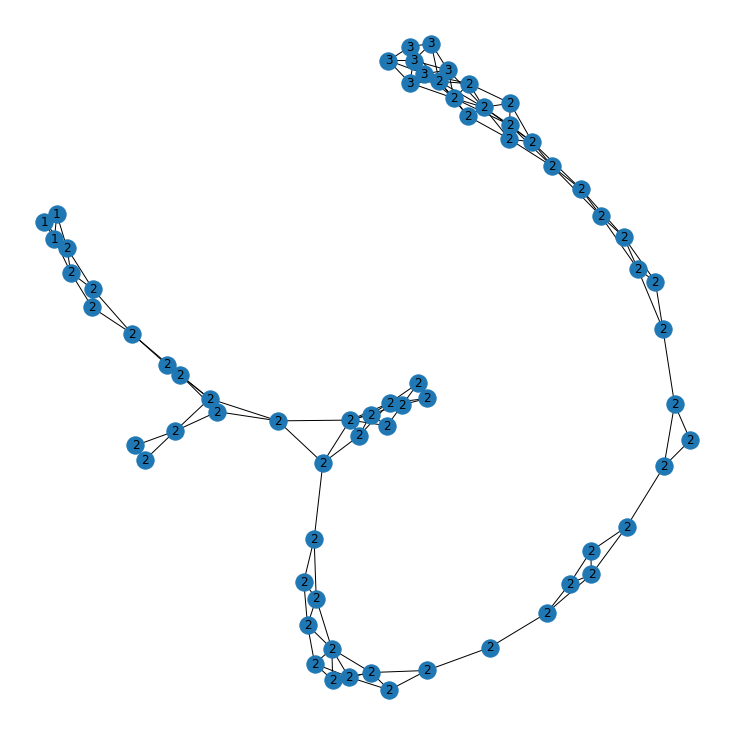

In [73]:
%matplotlib inline
plt.figure(figsize = (10, 10))
nx.draw_spring(segclass_graph, labels = labeldict, with_labels = True)
plt.show()

Vale, creo que lo suyo va a ser que tenga una graph solo con los voxeles q tienen segclass, otra con los voxeles vacíos y otra con todos los voxeles. Así, puedo seleccionar solo los de segclass y recorrerlos en la graph que tiene todos para ver cuales son los primeros voxeles vacíos a ''llenar'' (los que tengan menos distancia a los que tienen segclass), de forma que luego puedo recorrer dichos voxeles vacíos, mirar cual es la clase mayoritaria de sus vecinos y etiquetarlo con lo que toque :)

Es un poco similar a hacerlo con dataframes, pero supongo que esto tendrá sus ventajas nose... quizás el tema de saber rápidamente quienes son los vecinos en vez de hacer mil dataframes, la información ya está en un solo graph